In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import wandb
from tqdm import tqdm
from datetime import datetime
import pickle

import cv2
from skimage.io import imsave
from skimage.transform import resize
from skimage.measure import block_reduce
import skimage.segmentation as seg
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, average_precision_score

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize
from torchvision.transforms import InterpolationMode
# from kornia.geometry.transform import Resize
from kornia.augmentation import Normalize

from config import TrainConfig, GPU_ID
from dataio.dataloader import probe_data_folder, BraTS18Binary
from models.resnet import get_resnet50_attn_classifier
from models.unet import get_unet_encoder_classifier

figsize = (24, 24)

os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID

In [3]:
# Model directory and configuration

base_dir = "/hdd0/projects/regex/logs/unet_encoder_baseline/20210513_00:20:22/"
model_file = "unet_encoder_baseline__best__epoch=265_score=0.9738.pt"
config_file = "params.p"

config_handler = open(os.path.join(base_dir, config_file), 'rb')
params = pickle.load(config_handler)
params["weights"] = model_path = os.path.join(base_dir, model_file)

transforms = Compose([
                Normalize(mean=torch.tensor([149.56119, 165.83559, 166.13501, 112.61901]),
                          std=torch.tensor([636.8766, 653.8386, 759.8256, 718.83594])),
                Resize((256, 256), interpolation=InterpolationMode.NEAREST)])

mask_transforms = Resize((256, 256), interpolation=InterpolationMode.NEAREST)

In [4]:
# Load dataset
train_metadata, val_metadata, _ = probe_data_folder(params["data_path"],
                                                 train_frac=params["train_frac"],
                                                 bad_files=params["bad_files"],
                                                 subsample_frac=params["subsample_frac"])

# Datasets
# train_dataset = BraTS18Binary(params["data_path"],
#                         train_metadata,
#                         transforms=transforms,
#                         shuffle=True,
#                         get_mask=True,
#                         random_state=params["seed"],
#                         prefetch_data=params["prefetch_data"])
val_dataset = BraTS18Binary(params["data_path"],
                      val_metadata,
                      transforms=transforms,
                      mask_transforms=mask_transforms,
                      prefetch_data=params["prefetch_data"],
                      get_mask=True,
                      shuffle=True,
                      random_state=41)

# Dataloaders
# train_loader = DataLoader(dataset=train_dataset,
#                           num_workers=1,
#                           pin_memory=True,
#                           batch_size=1,
#                           shuffle=False)
val_loader = DataLoader(dataset=val_dataset,
                        num_workers=1,
                        pin_memory=True,
                        batch_size=1,
                        shuffle=False)

  Total of 208 train patients, 52 test patients
  Total of 16878 train slices, 4778 test slices


In [5]:
# Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# params["use_gpu"] = False
# device = "cpu"
model = get_unet_encoder_classifier(**params)

model = model.to(device)

Loading pretrained model from: '/hdd0/projects/regex/logs/unet_encoder_baseline/20210513_00:20:22/unet_encoder_baseline__best__epoch=265_score=0.9738.pt'
Total parameters: 4715522
Total trainable parameters: 4715522


In [23]:
y_true = []
y_pred = []
y_prob = []
images = []
masks = []
attrs = []
model.eval()

from captum.attr import LayerGradCam
ks = LayerGradCam(model, layer=model.bottleneck)


for j, sample in tqdm(enumerate(val_loader), total=len(val_loader)):
    # Image + Prediction
    if j > 100:
        break
    mri, (targets, masks_t) = sample
    mri_image = mri.detach().cpu().squeeze(0).squeeze(0).numpy()
    targ = targets.detach().cpu().item()
    mask = masks_t.detach().cpu()
    mask = mask_transforms(mask.unsqueeze(0)).squeeze(0)
    masks.append(mask.numpy())
    y_true.append(targ)
    
    
    mri, targets = mri.to(device), targets.to(device)
    attr = ks.attribute(mri, target=targets)
    attrs.append(attr.detach().cpu())
    
    outputs = model(mri)
    probs = torch.softmax(outputs, dim=1).cpu().detach()[0]
    y_prob.append(probs.numpy())
    y_pred.append(torch.argmax(probs).item())
    img_fname = f"image_{j:04d}_pred={str(probs.numpy().round(2))}_label={targ}.npy"
    images.append((img_fname, mri_image, mask))

  2%|▏         | 101/4778 [00:01<01:09, 67.17it/s]


In [24]:
print(balanced_accuracy_score(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print(confusion_matrix(y_true, y_pred, normalize="true"))

0.9801805337519622
[[51  1]
 [ 1 48]]
[[0.98076923 0.01923077]
 [0.02040816 0.97959184]]


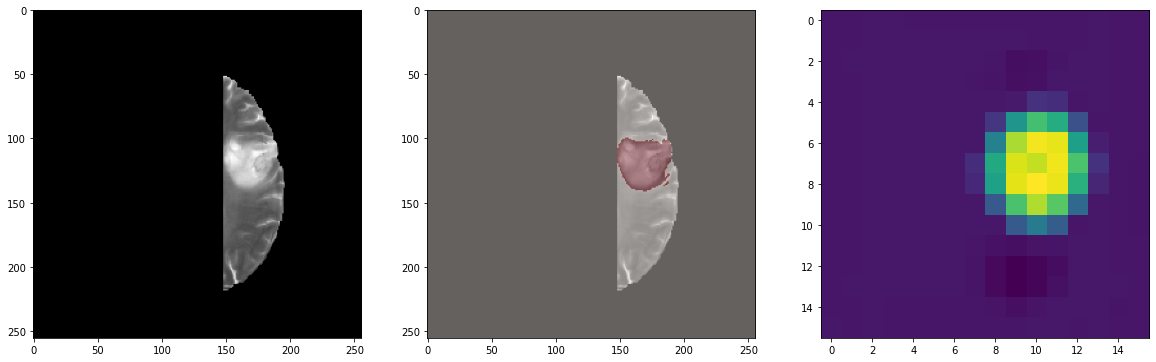

In [25]:
fig, ax = plt.subplots(1,3,figsize=(20, 20))
idx = 6
modality_idx = 2
img_fname, img, mask = images[idx]
img = img[modality_idx]
mask = mask[0]
heatmap = attrs[idx][0][0].numpy()
ax[0].imshow(img, cmap="gray")
ax[1].imshow(img, cmap="gray")
ax[1].imshow(mask, cmap="Reds", alpha=0.4)
ax[2].imshow(heatmap)

In [27]:
def get_ap(mask, heatmap, normalize_heatmap=True):
    mask = mask[0]
    if normalize_heatmap:
        heatmap -= heatmap.min()
        heatmap /= heatmap.max()
    if heatmap.shape != mask.shape:
        resize = Resize(mask.shape, interpolation=InterpolationMode.NEAREST)
        heatmap = resize(torch.tensor(heatmap).unsqueeze(0)).squeeze(0) / ((heatmap.shape[0] / mask.shape[0]) **2)
        heatmap = heatmap.numpy()
    return average_precision_score(mask.ravel(), heatmap.ravel())

In [28]:
ap_list = []
for i, (y, mask) in enumerate(zip(y_true, masks)):
    if y > 0:
        ap_score = get_ap(mask, attrs[i][0,0].numpy())
        ap_list.append(ap_score)
map_score = sum(ap_list) / len(ap_list)
print(map_score)

0.561402063942886
